Import Libraries

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.datasets import mnist
from keras import backend as k
import time
from tensorflow.keras.callbacks import EarlyStopping

# 1. Process MNIST dataset

Assign training and test data

In [7]:
num_classes = 10
img_rows, img_cols = 28,28
(x_train,y_train),(x_test,y_test) =   mnist.load_data()

Reshape the images

In [8]:
if k.image_data_format()=='channels_first':
    x_train=x_train.reshape(x_train.shape[0],img_rows,img_cols,1)
    x_test=x_test.reshape(x_test.shape[0],img_rows,img_cols,1)
else:
    x_train=x_train.reshape(x_train.shape[0],img_rows,img_cols,1)
    x_test=x_test.reshape(x_test.shape[0],img_rows,img_cols,1)

input_shape=(img_rows,img_cols,1)
x_train = x_train/255.0
x_test=x_test/255.0
print('x_train shape:',x_train.shape,'\nx_test shape:',x_test.shape)

x_train shape: (60000, 28, 28, 1) 
x_test shape: (10000, 28, 28, 1)


Convert class vectors to binary class matrices

# 2. CNN no Attention

Design the CNN architecture

In [9]:
from keras.models import Sequential
from keras import layers

In [10]:
model=Sequential()
model.add( layers.Input(shape=input_shape) )
model.add( layers.Conv2D(32,kernel_size=(3,3),activation='relu') )
model.add( layers.MaxPooling2D(pool_size=(2,2)) )
model.add( layers.Dropout(0.5) )
model.add( layers.Flatten() )
model.add( layers.Dense(num_classes,activation='softmax') )
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 10)                54090     
                                                                 
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
__________________________________________________

In [11]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']
             )
early_stopping = EarlyStopping(monitor='accuracy', patience=3)
tic=time.time()
hist = model.fit(x_train,y_train,
                batch_size=32,
                epochs=15,
                shuffle=True,
                callbacks=[early_stopping],
                validation_data=(x_test,y_test)
                )
toc=time.time()
training_time=toc-tic

Epoch 1/15
1875/1875 [==============================] - 21s 3ms/step - loss: 0.2638 - accuracy: 0.9227 - val_loss: 0.1051 - val_accuracy: 0.9706
Epoch 2/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1216 - accuracy: 0.9635 - val_loss: 0.0751 - val_accuracy: 0.9782
Epoch 3/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0985 - accuracy: 0.9701 - val_loss: 0.0652 - val_accuracy: 0.9784
Epoch 4/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0849 - accuracy: 0.9742 - val_loss: 0.0550 - val_accuracy: 0.9824
Epoch 5/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0761 - accuracy: 0.9768 - val_loss: 0.0520 - val_accuracy: 0.9823
Epoch 6/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0709 - accuracy: 0.9784 - val_loss: 0.0497 - val_accuracy: 0.9836
Epoch 7/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0636 - accuracy: 0.9796 - val_loss: 0.0491 - val_accuracy

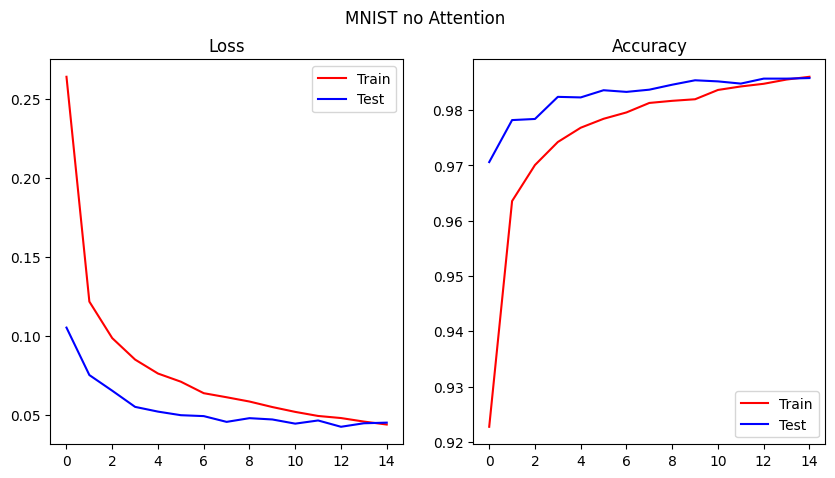

In [12]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.legend(["Train", "Test"], loc=0, frameon=True)
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], 'r')
plt.plot(hist.history['val_accuracy'], 'b')
plt.legend(["Train", "Test"], loc=0, frameon=True)
plt.suptitle("MNIST no Attention")
plt.show()

In [13]:
tic=time.time()
test_loss, test_acc = model.evaluate(x_test,y_test)
toc=time.time()
test_time=toc-tic
print("Training Time = {} s".format(np.round(training_time, 1)))
print("Testing Time = {} ms".format(np.round(test_time*1000, 1)))
print('Test Loss = {:.2f} %:'.format(np.round(test_loss, 3)*100))
print('Test Accuracy = {:.2f} %:'.format(np.round(test_acc, 3)*100))

313/313 [==============================] - 1s 3ms/step - loss: 0.0450 - accuracy: 0.9858
Training Time = 111.0 s
Testing Time = 1195.2 ms
Test Loss = 4.50 %:
Test Accuracy = 98.60 %:


# 3. CNN with Attention

Design the CNN architecture

In [14]:
from keras import layers, Model

In [20]:
inputs = keras.layers.Input(shape=input_shape)
conv = keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu', name="Conv2D_1")(inputs)
#Attention
attention = keras.layers.Conv2D(32, (3,3), padding='same', activation='sigmoid', name="Conv2D_2")(conv)
attention_mul = keras.layers.Multiply(name="Spatial_Attn")([conv, attention])
##########
pool = keras.layers.MaxPool2D(pool_size=(2,2))(attention_mul)
drop = keras.layers.Dropout(0.5, name="Drop_1")(pool)
flatten = keras.layers.Flatten(name="Flat_1")(drop)
dense2 = keras.layers.Dense(num_classes,activation='softmax',name="Output")(flatten)
modelAtt = keras.Model(inputs=inputs, outputs=dense2)

modelAtt.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 Conv2D_1 (Conv2D)              (None, 26, 26, 32)   320         ['input_4[0][0]']                
                                                                                                  
 Conv2D_2 (Conv2D)              (None, 26, 26, 32)   9248        ['Conv2D_1[0][0]']               
                                                                                                  
 Spatial_Attn (Multiply)        (None, 26, 26, 32)   0           ['Conv2D_1[0][0]',               
                                                                  'Conv2D_2[0][0]']         

In [21]:
modelAtt.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']
             )
early_stopping = EarlyStopping(monitor='accuracy', patience=3)
tic=time.time()
hist = modelAtt.fit(x_train,y_train,
                batch_size=32,
                epochs=15,
                shuffle=True,
                callbacks=[early_stopping],
                validation_data=(x_test,y_test)
                )
toc=time.time()
training_time=toc-tic

Epoch 1/15
1875/1875 [==============================] - 9s 4ms/step - loss: 0.2502 - accuracy: 0.9266 - val_loss: 0.0881 - val_accuracy: 0.9735
Epoch 2/15
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0961 - accuracy: 0.9709 - val_loss: 0.0596 - val_accuracy: 0.9811
Epoch 3/15
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0726 - accuracy: 0.9780 - val_loss: 0.0478 - val_accuracy: 0.9842
Epoch 4/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0618 - accuracy: 0.9804 - val_loss: 0.0418 - val_accuracy: 0.9851
Epoch 5/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0553 - accuracy: 0.9827 - val_loss: 0.0363 - val_accuracy: 0.9874
Epoch 6/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0503 - accuracy: 0.9841 - val_loss: 0.0380 - val_accuracy: 0.9875
Epoch 7/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0447 - accuracy: 0.9861 - val_loss: 0.0339 - val_accuracy:

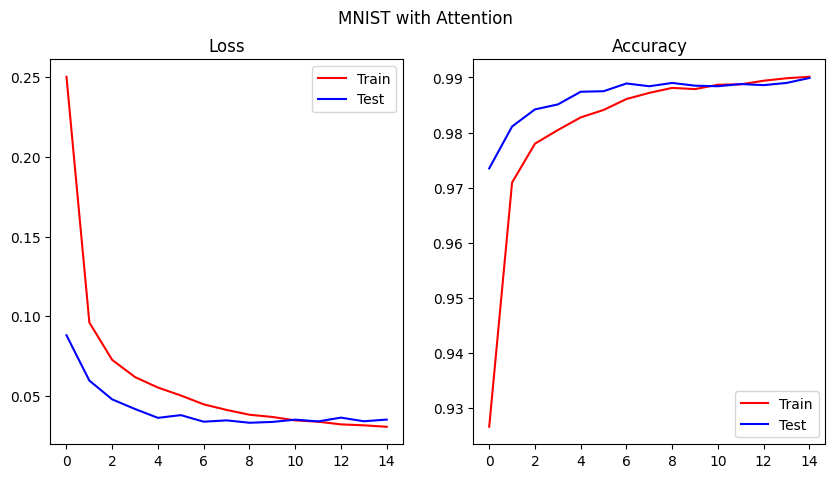

In [23]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.legend(["Train", "Test"], loc=0, frameon=True)
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], 'r')
plt.plot(hist.history['val_accuracy'], 'b')
plt.legend(["Train", "Test"], loc=0, frameon=True)
plt.suptitle("MNIST with Attention")
plt.show()

In [22]:
tic=time.time()
test_loss, test_acc = modelAtt.evaluate(x_test,y_test)
toc=time.time()
test_time=toc-tic
print("Training Time = {} s".format(np.round(training_time, 1)))
print("Testing Time = {} ms".format(np.round(test_time*1000, 1)))
print('Test Loss = {:.2f} %:'.format(np.round(test_loss, 3)*100))
print('Test Accuracy = {:.2f} %:'.format(np.round(test_acc, 3)*100))

313/313 [==============================] - 1s 3ms/step - loss: 0.0352 - accuracy: 0.9899
Training Time = 142.9 s
Testing Time = 918.3 ms
Test Loss = 3.50 %:
Test Accuracy = 99.00 %:
